# code2vec using Embeddings and NN

We are going to represent programs as token vectors and learn their representations using embeddings

We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 
 

* https://code.google.com/archive/p/word2vec/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

* https://www.cse.iitb.ac.in/~pb/papers/bionlp-acl17-medical-coding.pdf

* https://github.com/sloomba/protein2vec

* https://github.com/samiroid/usr2vec

* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

* http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

* Topic Modelling for Humans: https://radimrehurek.com/gensim/

* https://spacy.io/models/

* https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

* Code2Vec https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8031179&tag=1, https://arxiv.org/pdf/1803.09473.pdf, https://code2vec.org/

* From People2Vec to Emotional AI: http://people2vec.org/

* Using Word2vec for Music Recommendations: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

* Source code identifier embeddings: https://blog.sourced.tech/post/id2vec/

* Recommending Recommendation Systems: https://gab41.lab41.org/recommending-recommendation-systems-cc39ace3f5c1, https://github.com/Lab41/Misc/blob/master/blog/python2vec/Python2Vec%20Example.ipynb

* Python2Vec: Word Embeddings for Source Code: https://gab41.lab41.org/python2vec-word-embeddings-for-source-code-3d14d030fe8f

* Anything2Vec: https://gab41.lab41.org/anything2vec-e99ec0dc186

* AutoKeras: https://towardsdatascience.com/autokeras-the-killer-of-googles-automl-9e84c552a319, https://autokeras.com/

* Learning Program Embeddings to Propagate Feedback on Student Code: https://web.stanford.edu/~cpiech/bio/papers/programEncoding.pdf, https://github.com/chrispiech/refactoredEncoder

* Research at Code.org: https://code.org/research

* Cheatsheet: https://startupsventurecapital.com/essential-cheat-sheets-for-machine-learning-and-deep-learning-researchers-efb6a8ebd2e5

* DCU Deep Learning Summer School: https://telecombcn-dl.github.io/2018-dlcv/, https://www.slideshare.net/xavigiro/d1l2-the-neural-network-zoo-upc-2018-deep-learning-for-computer-vision

* Embeddings: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## VECTORIZE

**Programming data**: Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [3]:
!ls data/raw/programming_data.json

data/raw/programming_data.json


In [4]:
dataframe = pd.read_json('data/raw/programming_data.json')

In [5]:
dataframe.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(dataframe))

'591,707'

Grab only code submissions from Python modules:

In [7]:
PYTHON_MODULES = [
    'ca116', 
    'ca117', 
    'ca177', 
    'ca277', 
    'ca278',
]

In [8]:
dataframe = dataframe[dataframe['module'].isin(PYTHON_MODULES)]

In [9]:
'{:,}'.format(len(dataframe))

'490,820'

Target value:

In [10]:
dataframe.correct.value_counts()

False    296369
True     194451
Name: correct, dtype: int64

Remove comments:

In [11]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [12]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        code = remove_comments(
            df.at[index, 'upload']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'correct'])
        _labels.append(label)
    return _docs, _labels

In [13]:
docs, labels = get_docs_and_labels(dataframe)

In [14]:
'{:,}'.format(len(docs))

'490,820'

In [15]:
docs[0]

u'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [16]:
labels[0]

1

## 1) Programs as word vectors

https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/

In [17]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
NUM_WORDS = 2000 # Originally 231,659 words

In [19]:
def get_tokenizer():

    return Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [20]:
word_t = get_tokenizer()

In [21]:
word_t.fit_on_texts(docs)

In [22]:
# word_counts: a dictionary of words and their counts.
word_t.word_counts['if'] # word count

552539

In [23]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(word_t.document_count)

'Number docs: 490,820'

In [24]:
# word_index: a dictionary of words and their uniquely assigned integers.
word_t.word_index['if'] # index

4

In [25]:
# word_docs: a dictionary of words and how many documents each appeared in.
word_t.word_docs['if']

298487

In [26]:
import pickle

with open('word_tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
sequences = word_t.texts_to_sequences(docs)

In [28]:
sequences[0]

[17, 1, 358, 50, 1, 358, 6, 17, 3, 50]

Look at the lenght of these sequences:

In [29]:
len_seqs = [len(s) for s in sequences]

In [30]:
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(38.591420480013042, 38.577314137088699, 2358)

In [31]:
MAX_LENGTH = 50

Dictionary to transform a vector back to the program:

In [32]:
id_to_word = { v: k for k, v in word_t.word_index.items() }

In [33]:
id_to_word[1]

u'='

In [34]:
[id_to_word[index] for index in sequences[0]]

[u'a',
 u'=',
 u'int(raw_input())',
 u'b',
 u'=',
 u'int(raw_input())',
 u'print',
 u'a',
 u'+',
 u'b']

Pad documents:

In [35]:
from keras.preprocessing.sequence import pad_sequences

In [36]:
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [37]:
padded_docs[0]

array([ 17,   1, 358,  50,   1, 358,   6,  17,   3,  50,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Model:

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [39]:
def get_model():

    # define the model
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 100, input_length=MAX_LENGTH))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [40]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# fit the model
# model.fit(padded_docs, labels, epochs=2, verbose=1)

model.fit(padded_docs, 
          labels,
          batch_size=128,
          epochs=10,
          validation_split=0.2)

Train on 392656 samples, validate on 98164 samples
Epoch 1/10
392656/392656 [==============================] - 27s 69us/step - loss: 0.5926 - acc: 0.6774 - val_loss: 0.6810 - val_acc: 0.6147
Epoch 2/10
392656/392656 [==============================] - 27s 69us/step - loss: 0.5331 - acc: 0.7251 - val_loss: 0.7016 - val_acc: 0.6434
Epoch 3/10
392656/392656 [==============================] - 27s 70us/step - loss: 0.5079 - acc: 0.7428 - val_loss: 0.7539 - val_acc: 0.6272
Epoch 4/10
392656/392656 [==============================] - 27s 70us/step - loss: 0.4927 - acc: 0.7530 - val_loss: 0.7875 - val_acc: 0.6314
Epoch 5/10
392656/392656 [==============================] - 26s 67us/step - loss: 0.4824 - acc: 0.7592 - val_loss: 0.8183 - val_acc: 0.6348
Epoch 6/10
392656/392656 [==============================] - 27s 68us/step - loss: 0.4746 - acc: 0.7646 - val_loss: 0.8363 - val_acc: 0.6419
Epoch 7/10
392656/392656 [==============================] - 27s 68us/step - loss: 0.4688 - acc: 0.7674 - val_

In [42]:
# evaluate the model
word_loss, word_accuracy = model.evaluate(padded_docs, labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (word_accuracy * 100, word_loss * 100))

490820/490820 [==============================] - 25s 51us/step
Accuracy: 75.381199, Loss: 53.781378


In [43]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [44]:
embeddings = get_embeddings(model)

Embedding Layer shape: (2000, 100)


In [45]:
embeddings[0]

array([  4.94930968e-02,  -8.18745175e-04,  -1.10700885e-02,
         4.03147191e-02,  -1.12788761e-02,  -1.62172765e-02,
         1.16454083e-02,   5.75098488e-03,  -2.26282030e-02,
        -2.49034986e-02,  -5.09824743e-03,   2.02895794e-02,
        -1.19545925e-02,  -2.18008757e-02,   1.33883033e-03,
        -2.31753085e-02,   3.92109677e-02,  -4.33672518e-02,
        -1.10548846e-02,   9.06962669e-05,   2.03008242e-02,
        -5.02354931e-03,   1.98267028e-03,   5.22298040e-03,
        -7.27799581e-03,  -2.64213164e-03,   7.62963761e-03,
        -1.99021976e-02,   1.37797026e-02,  -1.78859644e-02,
        -1.37943006e-03,   1.76103394e-02,   2.00942177e-02,
         1.85444094e-02,  -2.58710179e-02,  -1.47516727e-02,
        -1.57711580e-02,   2.49769893e-02,   1.61062330e-02,
         1.01841912e-02,  -1.65706724e-02,   1.34776402e-02,
         6.51498046e-03,  -1.29871983e-02,   7.67190428e-03,
         3.91676873e-02,  -4.17777570e-03,  -1.92180406e-02,
        -9.62508284e-03,

In [46]:
np.save('data/processed/word_embeddings', embeddings)

In [47]:
from sklearn.decomposition import PCA

def get_pca(embeddings):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components

In [48]:
pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.12281886  0.05322424] Total: 0.17604310438


In [49]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [50]:
top_words = get_top_words(word_t)

In [51]:
def plot_embeddings(low_dim_embs, id_to_word, top_words, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
        
        i += 1

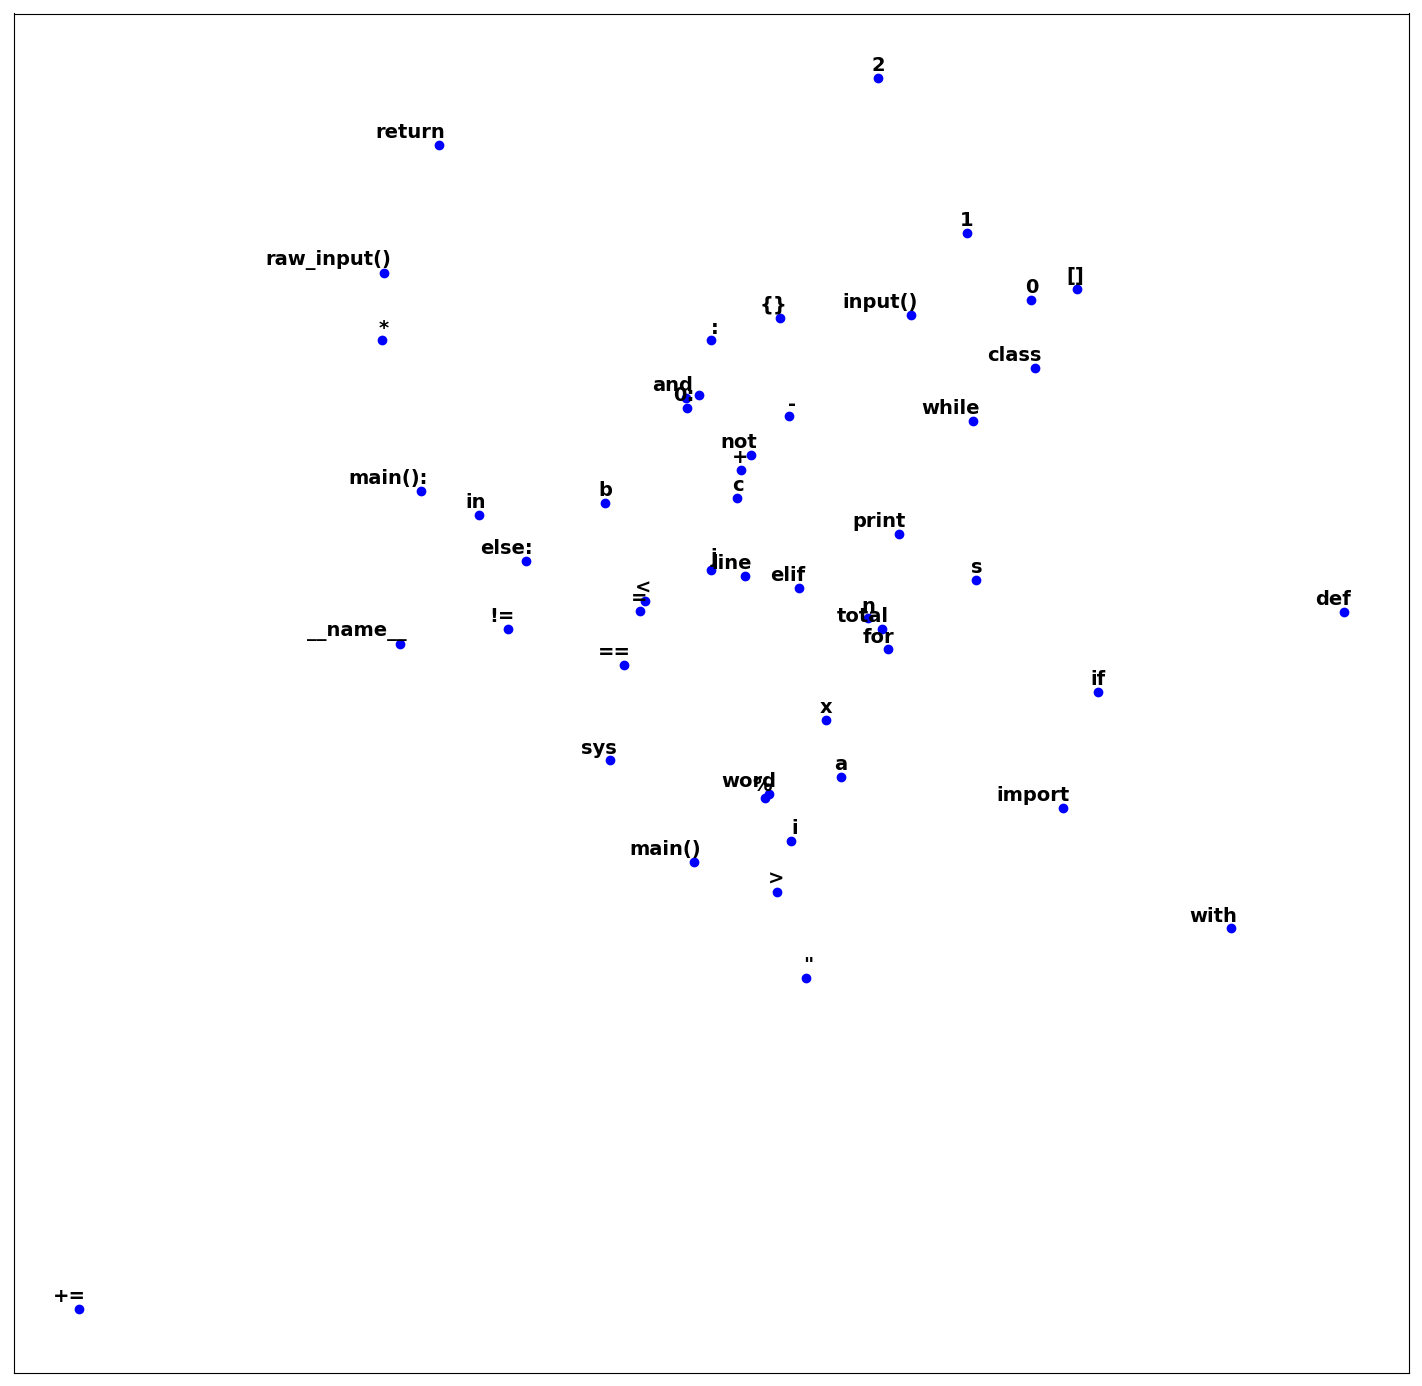

In [52]:
plot_embeddings(pca, id_to_word, top_words, figsize=(18, 18))

Measure the distance between vectors:

In [98]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, word1, word2):
    
    print euclidean(embeddings[word_t.word_index[word1]], 
                    embeddings[word_t.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, word1, word2):
    
    print cosine(embeddings[word_t.word_index[word1]], 
                    embeddings[word_t.word_index[word2]])

In [99]:
get_vector_distance(embeddings, '<', '>')

0.938710451126


In [ ]:
get_vector_cosine_distance(embeddings, '<', '>')

In [83]:
get_vector_distance(embeddings, '==', '!=')

0.960970580578


In [84]:
get_vector_distance(embeddings, 'if', 'elif')

0.93246281147


In [85]:
get_vector_distance(embeddings, 'elif', 'else:')

0.945038378239


In [86]:
get_vector_distance(embeddings, '+', '-')

0.929007351398


In [87]:
get_vector_distance(embeddings, '<', '>')

0.938710451126


In [88]:
get_vector_distance(embeddings, 'for', 'while')

1.14743411541


In [89]:
get_vector_distance(embeddings, 'def', 'import')

1.02430939674


## 2) Programs as tokens

In [65]:
from tokenize import generate_tokens
from StringIO import StringIO

In [66]:
token_ids = []
token_words = []
token_labels = []
i = 0
while i < len(docs):
    doc = docs[i]
    label = labels[i]
    try:
        tokens = [(t[0], t[1]) for t in list(generate_tokens(StringIO(doc).readline))]
        # Token ID
        token_ids.append(
            [token[0] for token in tokens]
        )
        # Token
        token_words.append(
            [token[1] for token in tokens]
        )
        token_labels.append(
            label
        )
    except:
        pass
    i += 1

In [67]:
'Number encoded docs: {:,}'.format(len(token_words))

'Number encoded docs: 472,087'

In [68]:
token_docs = [
    ' '.join(array) for array in token_words
]

In [69]:
token_t = get_tokenizer()

token_t.fit_on_texts(token_docs)

In [70]:
# saving
with open('token_tokenizer.pickle', 'wb') as handle:
    pickle.dump(token_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
token_sequences = token_t.texts_to_sequences(token_docs)

id_to_token = { v: k for k, v in token_t.word_index.items() }

token_padded_docs = pad_sequences(token_sequences, maxlen=MAX_LENGTH, padding='post')

In [72]:
token_model = get_model()

token_model.fit(token_padded_docs, token_labels, epochs=2, verbose=1)

token_loss, token_accuracy = token_model.evaluate(token_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
472087/472087 [==============================] - 90s 190us/step - loss: 0.5657 - acc: 0.7031
Epoch 2/2
472087/472087 [==============================] - 29s 62us/step
Accuracy: 76.639899, Loss: 48.093902


In [73]:
token_embeddings = get_embeddings(token_model)

token_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ 0.04148865,  0.02766778,  0.01835206,  0.03194752,  0.00533432,
       -0.03851268,  0.03994836, -0.06062297, -0.00155046,  0.00925566,
        0.06421266,  0.05036457, -0.0241284 ,  0.02079818,  0.02357274,
       -0.05364672,  0.02772287,  0.04929812,  0.04657805, -0.02795615,
       -0.02518824,  0.03379288, -0.2047502 ,  0.00859291, -0.0492834 ,
        0.00413345,  0.04927433,  0.02008592,  0.01742374,  0.04870128,
       -0.0086237 , -0.04184489,  0.03370985,  0.05431503, -0.06177825,
        0.08669699, -0.01359059,  0.01396332,  0.06959825,  0.0340691 ,
        0.08003269, -0.00280681,  0.01324732, -0.04547545, -0.02565456,
        0.14284787, -0.07687578, -0.04861164, -0.00308221,  0.02437217,
       -0.03985604, -0.06384914, -0.00489227, -0.05065764,  0.03555262,
       -0.05215216, -0.00068178,  0.02152949,  0.00209022,  0.00912038,
       -0.01713862,  0.03342502, -0.03933968,  0.09446074, -0.03497574,
       -0.01847302, -0.02518146, -0.02684282,  0.00056676,  0.00

In [74]:
np.save('data/processed/token_embeddings', token_embeddings)

In [75]:
token_pca = get_pca(token_embeddings)

token_top_words = get_top_words(token_t, N=100)

PCA explained variance ratio: [ 0.16604702  0.05359349] Total: 0.219640512019


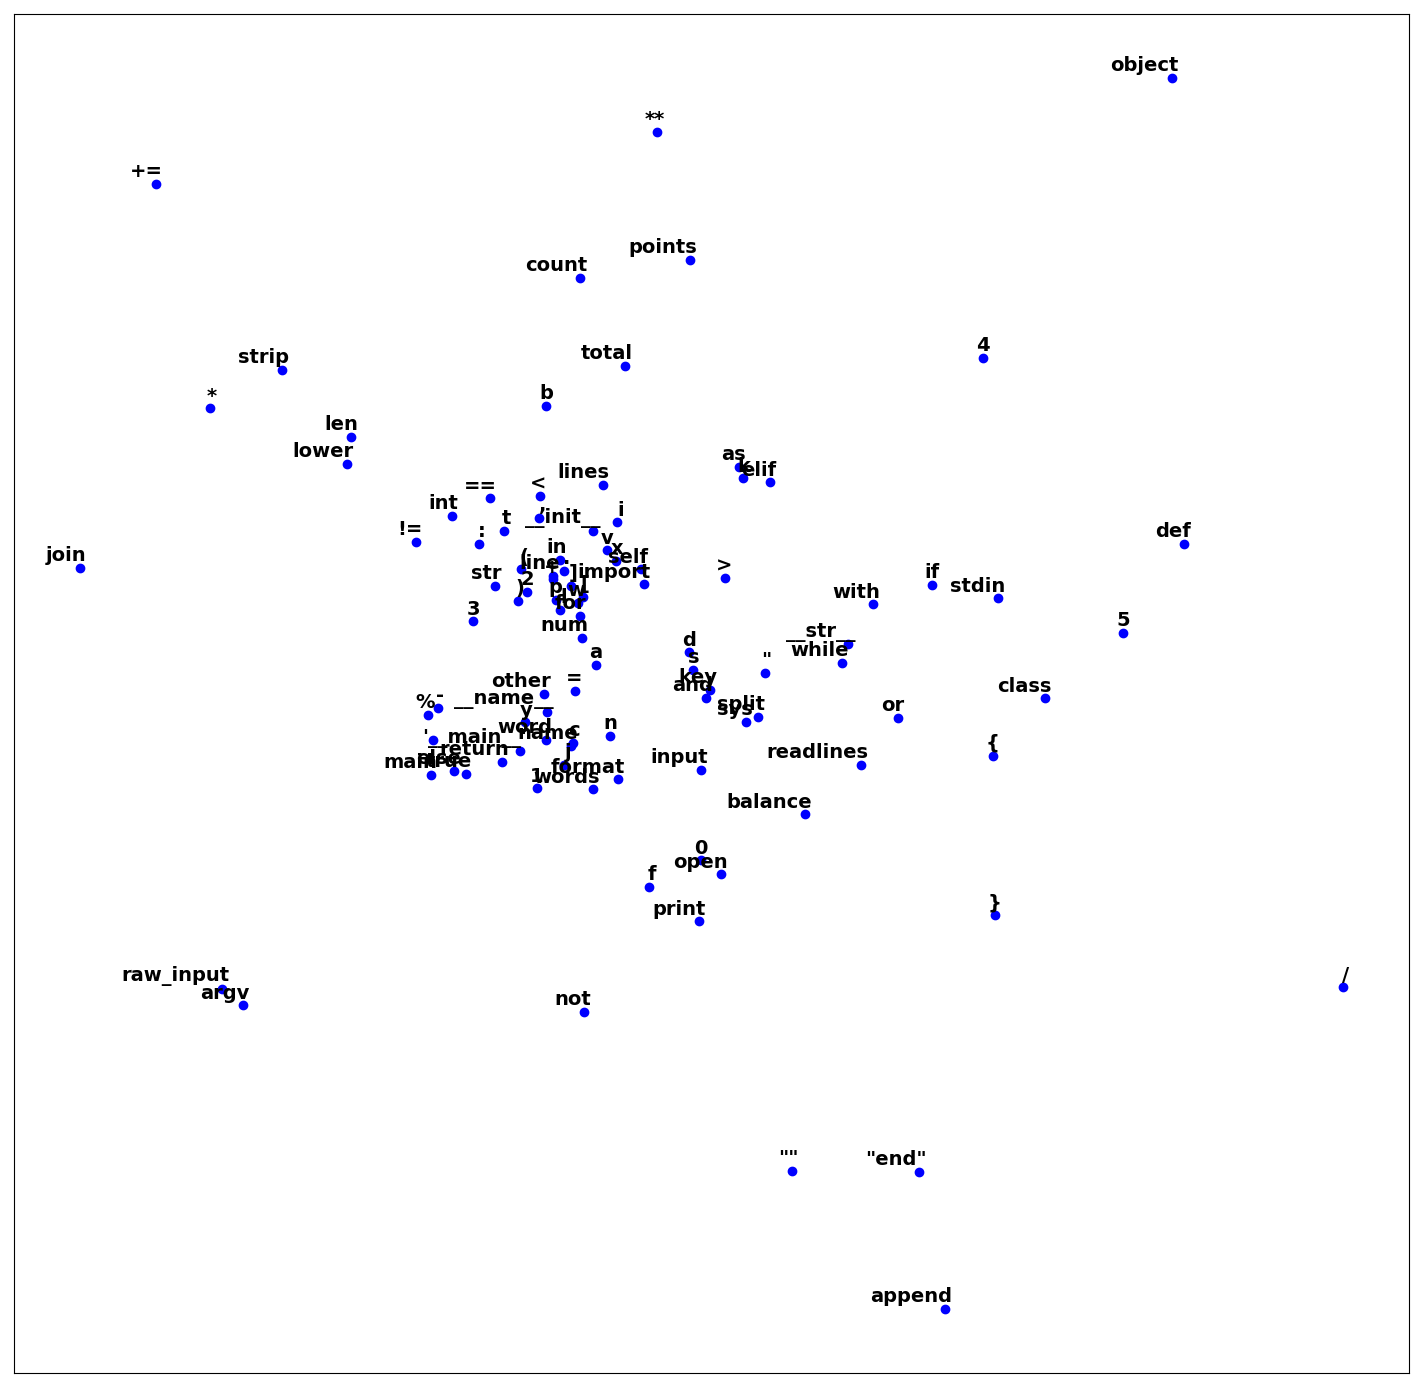

In [76]:
plot_embeddings(token_pca, id_to_token, token_top_words, figsize=(18, 18))

In [100]:
get_vector_distance(token_embeddings, '<', '>')

1.15453636646


In [120]:
get_vector_distance(token_embeddings, '+', '-')

1.14417457581


In [101]:
get_vector_distance(token_embeddings, '==', '!=')

0.870918273926


In [103]:
get_vector_distance(token_embeddings, 'if', 'elif')

1.04767286777


In [104]:
get_vector_distance(token_embeddings, 'elif', 'else:')

1.3038841486


In [121]:
get_vector_distance(token_embeddings, '*', '/')

1.46174263954


In [106]:
get_vector_distance(token_embeddings, 'for', 'while')

0.900842547417


In [115]:
get_vector_distance(token_embeddings, '{', '[')

2.69911980629


In [116]:
get_vector_distance(token_embeddings, '}', ']')

2.33708667755


In [125]:
get_vector_distance(token_embeddings, '[', ']')

3.0679192543


In [123]:
get_vector_distance(token_embeddings, '(', ')')

3.49301576614


## 3) Programs as Abstract Syntax Trees

In [62]:
# TODO

## SCORE

In [128]:
scores = {
    'Word NN': (word_loss, word_accuracy),
    'Word Token NN': (token_loss, token_accuracy),
    #'Category Token NN': (token_loss, token_accuracy),
    #'AST NN': (ast_loss, ast_accuracy),
}

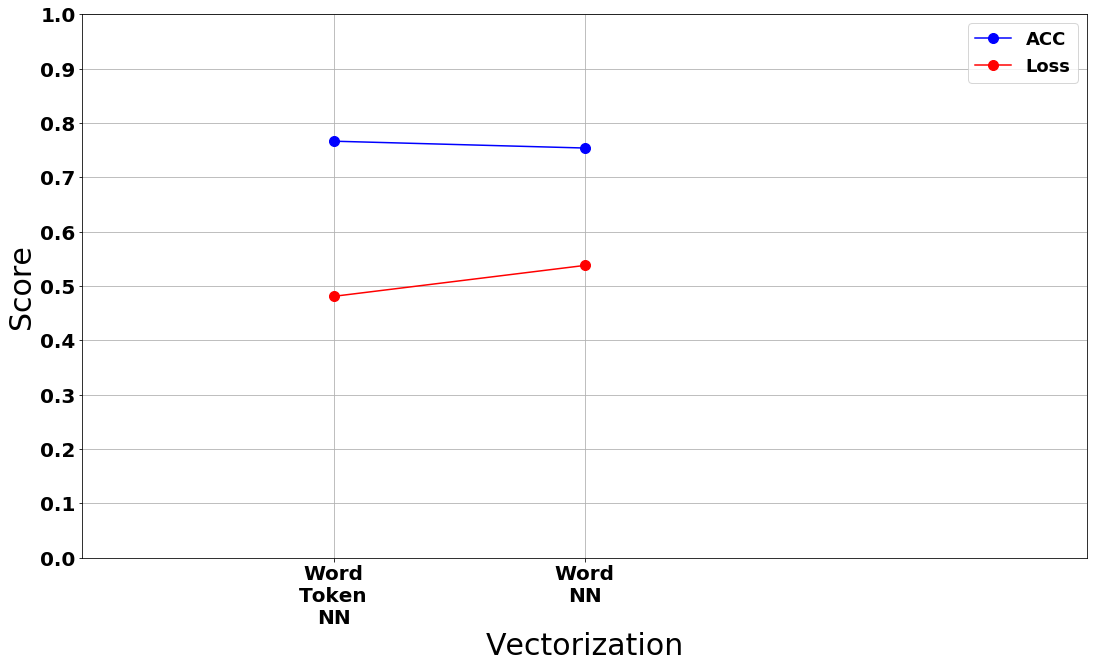

In [129]:
x = range(len(scores))
acc = [v[1] for k, v in scores.items()]
loss = [v[0] for k, v in scores.items()]
keys = [k.replace(' ', '\n') for k, v in scores.items()]

plt.subplots(figsize=(18, 10))
plt.grid()
plt.plot(x, acc, 'o-', color='b', label='ACC', markersize=10)
plt.plot(x, loss, 'o-', color='red', label='Loss', markersize=10)
plt.ylabel('Score', fontsize=30)
plt.xlabel('Vectorization', fontsize=30)
plt.xlim([-1, len(scores) + 1])
plt.xticks(x, keys)
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="upper right", fontsize=18)